<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S7/EVA04_S7_40K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [3]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
import eva4datatransforms
from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans = eva4datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()


In [6]:
tuple(fillmeans)

(125, 122, 113)

# Dataset and Creating Train/Test Split

In [7]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 3, 32, 32])
torch.Size([128])


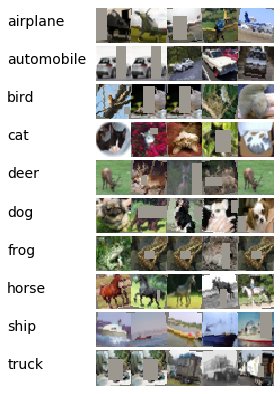

In [9]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
import eva4models
import torch
model = eva4models.Cfar10Net3()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 16, 32, 32]              48
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             144
            Conv2d-6           [-1, 16, 32, 32]             256
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             144
           Conv2d-10           [-1, 16, 32, 32]             256
      BatchNorm2d-11           [-1, 16, 32, 32]              32
             ReLU-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 16,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

# Let's Train and test our model

In [11]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 20
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.407978).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0124, Accuracy: 41.50%; Test set: Average loss: 1.4080, Accuracy: 49.86%
Learning Rate = 0.052181


Validation loss decreased (1.407978 --> 1.118417).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0098, Accuracy: 54.51%; Test set: Average loss: 1.1184, Accuracy: 60.16%
Learning Rate = 0.140093


Epoch: 3, Train set: Average loss: 0.0089, Accuracy: 59.15%; Test set: Average loss: 1.4225, Accuracy: 50.66%
Learning Rate = 0.260161


Validation loss decreased (1.118417 --> 1.005694).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0082, Accuracy: 62.49%; Test set: Average loss: 1.0057, Accuracy: 64.57%
Learning Rate = 0.380186


Validation loss decreased (1.005694 --> 0.942179).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0078, Accuracy: 64.43%; Test set: Average loss: 0.9422, Accuracy: 66.48%
Learning Rate = 0.467980


Epoch: 6, Train set: Average loss: 0.0074, Accuracy: 66.42%; Test set: Average loss: 1.0241, Accuracy: 67.09%
Learning Rate = 0.500000


Validation loss decreased (0.942179 --> 0.924207).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0071, Accuracy: 68.11%; Test set: Average loss: 0.9242, Accuracy: 68.66%
Learning Rate = 0.493700


Validation loss decreased (0.924207 --> 0.866741).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0068, Accuracy: 68.99%; Test set: Average loss: 0.8667, Accuracy: 70.02%
Learning Rate = 0.475180


Validation loss decreased (0.866741 --> 0.794121).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0067, Accuracy: 69.89%; Test set: Average loss: 0.7941, Accuracy: 72.28%
Learning Rate = 0.445369


Epoch: 10, Train set: Average loss: 0.0065, Accuracy: 70.64%; Test set: Average loss: 0.8394, Accuracy: 72.18%
Learning Rate = 0.405761


Validation loss decreased (0.794121 --> 0.666107).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0063, Accuracy: 71.81%; Test set: Average loss: 0.6661, Accuracy: 76.74%
Learning Rate = 0.358342


Epoch: 12, Train set: Average loss: 0.0062, Accuracy: 72.21%; Test set: Average loss: 0.7031, Accuracy: 75.66%
Learning Rate = 0.305491


Epoch: 13, Train set: Average loss: 0.0060, Accuracy: 72.98%; Test set: Average loss: 0.6776, Accuracy: 76.70%
Learning Rate = 0.249858


Epoch: 14, Train set: Average loss: 0.0058, Accuracy: 73.63%; Test set: Average loss: 0.6844, Accuracy: 76.20%
Learning Rate = 0.194231


Validation loss decreased (0.666107 --> 0.615549).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0056, Accuracy: 74.62%; Test set: Average loss: 0.6155, Accuracy: 78.80%
Learning Rate = 0.141401


Validation loss decreased (0.615549 --> 0.594961).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0055, Accuracy: 75.15%; Test set: Average loss: 0.5950, Accuracy: 79.77%
Learning Rate = 0.094017


Validation loss decreased (0.594961 --> 0.579301).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0053, Accuracy: 76.31%; Test set: Average loss: 0.5793, Accuracy: 79.92%
Learning Rate = 0.054454


Validation loss decreased (0.579301 --> 0.556205).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0051, Accuracy: 76.98%; Test set: Average loss: 0.5562, Accuracy: 80.48%
Learning Rate = 0.024697


Validation loss decreased (0.556205 --> 0.552229).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0049, Accuracy: 77.90%; Test set: Average loss: 0.5522, Accuracy: 80.67%
Learning Rate = 0.006238


Validation loss decreased (0.552229 --> 0.548293).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0049, Accuracy: 78.03%; Test set: Average loss: 0.5483, Accuracy: 81.04%
Learning Rate = 0.000002

